In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from ensemble.sgh import SGH

#from deslib.static.oracle import Oracle
from ensemble.oracle import Oracle

from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier, Perceptron
from tqdm import tqdm
import pandas as pd
import numpy as np
import utils

plt.style.use('ggplot')


ds_name, X, y = utils.data_customer()

seed = 100000
base_learner = Perceptron()
kf = KFold(n_splits=5)
results = {'oracle_accuracy': [], 'oracle_std': [], 'ensemble_length': []}

"""
 - verifique quantas instâncias por classe foram incorretamente classificadas; 
 - verifique quantos hiperplanos por classe foram gerados
"""

pool_classifiers = SGH(base_estimator=base_learner)
scores = list()
fold = 1
for train_index, test_index in kf.split(X):
    #print("Fold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    pool_classifiers.fit(X_train, y_train)    
    oracle = Oracle(pool_classifiers)
    
    
    score = oracle.score(X_test, y_test)
    scores.append(score)
    fold += 1
    
print("Acc (mean): %.2f" % np.mean(scores))
print("STD: %.2f" % np.std(scores))

Acc (mean): 1.00
STD: 0.00


In order to avoid issues with mismatch shapes between summaries matrices of each fold, we pre-allocate a matrix with zeros and fills it with current values of each summary.

In [30]:
summary = []
for df_index in range(len(pool_classifiers.misclassified_data_frames)):
    alloc = np.zeros((len(np.unique(y)), pool_classifiers.n_estimators))
    for i in range(0, alloc.shape[0]):
        for j in range(0, alloc.shape[1]):
            try:
                alloc[i,j] = pool_classifiers.misclassified_data_frames[df_index][i,j]
            except:
                pass
    summary.append(alloc)

In [31]:
misclassified = pd.DataFrame(np.round(np.mean(summary, axis=0)))
misclassified['labels'] = misclassified.index
misclassified.columns = ['H_%s' % it for it in misclassified.columns[:-1]] + [misclassified.columns[-1]]
misclassified

,H_0,H_1,H_2,H_3,H_4,H_5,H_6,H_7,labels
0,213.0,213.0,213.0,72.0,7.0,1.0,81.0,6.0,0
1,174.0,79.0,79.0,79.0,79.0,17.0,1.0,0.0,1
2,225.0,225.0,81.0,81.0,81.0,66.0,0.0,0.0,2
3,189.0,74.0,26.0,8.0,1.0,1.0,0.0,0.0,3


In [32]:
misclassified.to_latex("results/sgh/%s_summary.tex" % ds_name)

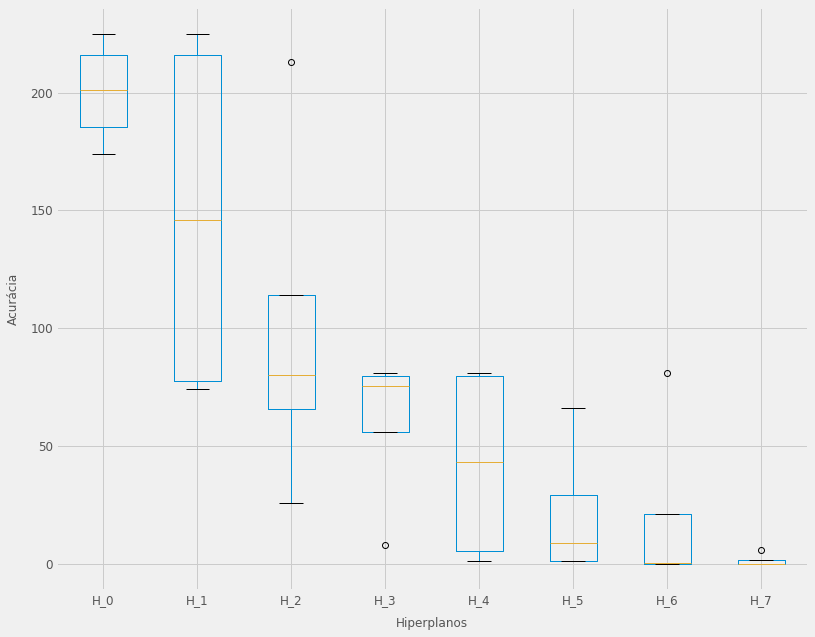

In [40]:
with plt.style.context('fivethirtyeight'):
    misclassified.iloc[:, :-1].boxplot(figsize=(12,10), grid=True, fontsize=12)
    plt.xlabel('Hiperplanos', labelpad=10, fontsize=12)
    plt.ylabel('Acurácia', labelpad=10, fontsize=12)
    plt.savefig("results/sgh/%s_boxplot.pdf" % (ds_name))
    plt.show();
    

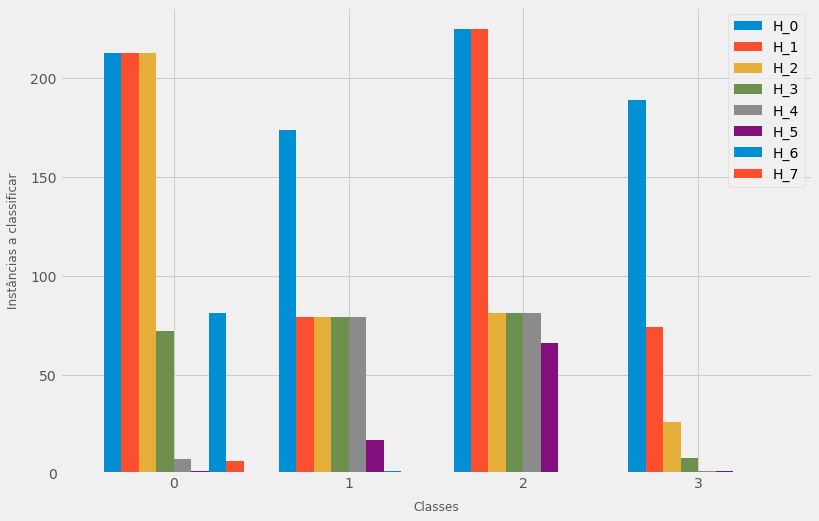

In [37]:
with plt.style.context('fivethirtyeight'):
    misclassified.iloc[:, :-1].plot(kind='bar', width=.80, figsize=(12,8), rot=0)
    plt.xlabel('Classes', labelpad=10, fontsize=12)
    plt.ylabel('Instâncias a classificar', labelpad=10, fontsize=12)
    plt.savefig("results/sgh/%s_bar.pdf" % ds_name)
    plt.show();
    

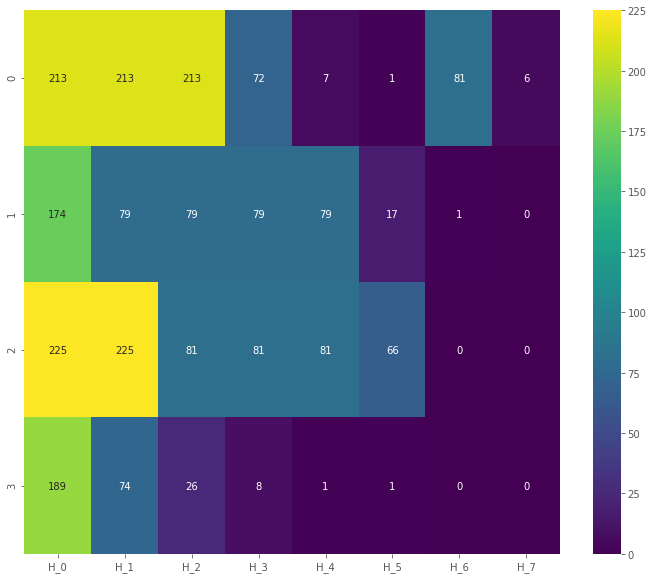

In [38]:
with plt.style.context('ggplot'):   
    plt.figure(figsize=(12,10))
    plt.xlabel('Hiperplanos')
    plt.ylabel('Quantidade média de classes')
    sns.heatmap(misclassified.iloc[:, :-1], annot=True, fmt="g", cmap='viridis')
    plt.savefig("results/sgh/%s_heatmap.pdf" % (ds_name))
    plt.show()